Detected 39 Blue Bump candidates using GMM.
Excluding SN Ia: SN1993L - Insufficient data points (1)
Excluding SN Ia: SN1991bg - Insufficient data points (1)
Excluding SN Ia: SN2001bg - Insufficient data points (2)
Excluding SN Ia: SN2007sr - Insufficient data points (3)
Excluding SN Ia: SN1992A - Insufficient data points (5)
Excluding SN Ia: SN2001C - Insufficient data points (1)
Excluding SN Ia: SN1997bp - Insufficient data points (4)
Excluding SN Ia: SN2014dt - Insufficient data points (1)

After filtering: 31 candidates with >5 data points remaining.

Ranked Blue Bump Candidates (Best to Worst):
1. SN Ia: SN2011fe, GMM Score: 1.0000, Data Points: 81
2. SN Ia: SN1991T, GMM Score: 1.0000, Data Points: 21
3. SN Ia: SN1972E, GMM Score: 1.0000, Data Points: 16
4. SN Ia: SN2000E, GMM Score: 1.0000, Data Points: 10
5. SN Ia: SN1996X, GMM Score: 1.0000, Data Points: 7
6. SN Ia: SN1994D, GMM Score: 1.0000, Data Points: 35
7. SN Ia: SN2000cx, GMM Score: 1.0000, Data Points: 24
8. SN Ia: SN199

100%|██████████| 5000/5000 [00:10<00:00, 460.87it/s]


Bayesian estimate: 8.11% with 68% CI [6.79%, 9.68%]


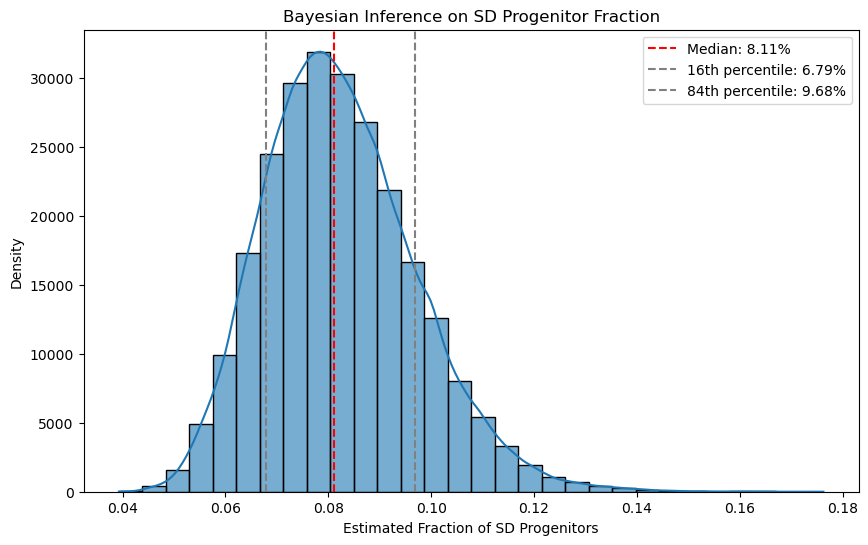

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emcee
from sklearn.mixture import GaussianMixture
from scipy.interpolate import interp1d
import os

# Load the supernova magnitude data from CSV
csv_file = "/Users/ishaanpadmawar/Downloads/Blue Bump Project/magnitudesPlain.csv"
data = pd.read_csv(csv_file)

# --- Check for missing columns ---
required_columns = {"name", "b_time", "blue", "bresult"}  # bresult is now always required
missing_columns = required_columns - set(data.columns)
if missing_columns:
    raise KeyError(f"Missing required columns in CSV: {missing_columns}")

# --- Split "b_time" and "blue" into multiple values and remove brackets ---
def robust_float_conversion(value):
    try:
        return float(value)
    except (ValueError, TypeError):  # Handles invalid string/NaN
        return np.nan

def process_list_string(s):
    if pd.isna(s) or not isinstance(s, str):  # Handle NaN or non-string
        return []
    s = s.strip("[]")  # Remove brackets if present
    values = s.split(",")
    return [robust_float_conversion(value.strip()) for value in values]

data["b_time"] = data["b_time"].apply(process_list_string)
data["blue"] = data["blue"].apply(process_list_string)

# --- Outlier Detection using Gaussian Mixture Models (GMM) ---
def detect_outliers_gmm(data, column="bresult"):
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
    data_vals = data[[column]].dropna().values
    gmm.fit(data_vals)
    scores = gmm.predict_proba(data_vals)[:, 1]
    return data, scores  # Return both data and scores

data, gmm_scores = detect_outliers_gmm(data, "bresult")
threshold = np.percentile(gmm_scores, 90)
blue_excess_candidates = data.iloc[np.where(gmm_scores > threshold)]

print(f"Detected {len(blue_excess_candidates)} Blue Bump candidates using GMM.")

# --- Filter out candidates with insufficient data points ---
filtered_candidates = []
for idx, candidate in blue_excess_candidates.iterrows():
    sn_name = candidate["name"]
    sn_data = data[data["name"] == sn_name].copy()
    
    # Explode lists to get individual data points
    sn_data_exploded = sn_data.explode(["b_time", "blue"])
    
    # Convert to numeric and drop NaN values
    sn_data_exploded["b_time"] = pd.to_numeric(sn_data_exploded["b_time"], errors="coerce")
    sn_data_exploded["blue"] = pd.to_numeric(sn_data_exploded["blue"], errors="coerce")
    sn_data_clean = sn_data_exploded.dropna(subset=["b_time", "blue"])
    
    # Count valid data points
    data_point_count = len(sn_data_clean)
    
    # Only keep candidates with more than 5 data points
    if data_point_count > 5:
        # Save both index and score
        original_idx = np.where(gmm_scores > threshold)[0][blue_excess_candidates.index.get_loc(idx)]
        filtered_candidates.append((idx, data_point_count, gmm_scores[original_idx]))
    else:
        print(f"Excluding SN Ia: {sn_name} - Insufficient data points ({data_point_count})")

# Create filtered dataframe
if filtered_candidates:
    filtered_indices = [idx for idx, _, _ in filtered_candidates]
    blue_excess_candidates = blue_excess_candidates.loc[filtered_indices].copy()
    
    # Add data point count and GMM score directly
    blue_excess_candidates["data_points"] = [count for _, count, _ in filtered_candidates]
    blue_excess_candidates["gmm_score"] = [score for _, _, score in filtered_candidates]
    
    print(f"\nAfter filtering: {len(blue_excess_candidates)} candidates with >5 data points remaining.")
else:
    blue_excess_candidates = pd.DataFrame()  # Empty DataFrame if no candidates remain
    print("No candidates with sufficient data points found.")

# --- Rank Blue Bump Candidates ---
if not blue_excess_candidates.empty:
    ranked_candidates = blue_excess_candidates.sort_values(by="gmm_score", ascending=False)

    print("\nRanked Blue Bump Candidates (Best to Worst):")
    for i, (sn_name, score, points) in enumerate(zip(
        ranked_candidates["name"], 
        ranked_candidates["gmm_score"],
        ranked_candidates["data_points"]
    )):
        print(f"{i + 1}. SN Ia: {sn_name}, GMM Score: {score:.4f}, Data Points: {points}")

    # --- Plot Blue Bump Candidates ---
    output_dir = "blue_bump_lightcurves"
    os.makedirs(output_dir, exist_ok=True)

    for sn_name in ranked_candidates["name"]:
        plt.figure(figsize=(10, 5))
        sn_data = data[data["name"] == sn_name].copy()

        sn_data_exploded = sn_data.explode(["b_time", "blue"])  # Explode lists

        sn_data_exploded["b_time"] = pd.to_numeric(sn_data_exploded["b_time"], errors="coerce")
        sn_data_exploded["blue"] = pd.to_numeric(sn_data_exploded["blue"], errors="coerce")

        plt.plot(sn_data_exploded["b_time"], sn_data_exploded["blue"], 'bo', label="Blue", markersize=3)

        plt.xlabel("Time")
        plt.ylabel("Blue")
        plt.title(f"SN Ia: {sn_name} - Blue Light Curve")
        plt.gca().invert_yaxis()
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.5)

        filename = os.path.join(output_dir, f"SN_{sn_name}_blue_curve.png")
        plt.savefig(filename, dpi=300)
        plt.close()
        print(f"Saved light curve plot for SN Ia: {sn_name} to {filename}")

    print(f"Blue light curve plots saved to '{output_dir}'.")
else:
    print("No Blue Bump candidates found.")

# --- Light Curve Interpolation ---
def linear_interpolation(time, mag):
    valid_idx = ~np.isnan(mag)
    if valid_idx.sum() < 2:
        return np.full_like(mag, np.nan)
    try:
        interp_func = interp1d(time[valid_idx], mag[valid_idx], kind="linear", fill_value="extrapolate")
        return interp_func(time)
    except Exception as e:
        print(f"Interpolation failed: {e}")
        return np.full_like(mag, np.nan)

# Apply interpolation to each supernova
for sn in data["name"].unique():
    sn_subset = data[data["name"] == sn].copy()
    sn_subset = sn_subset.explode(["b_time", "blue"])

    sn_subset["b_time"] = pd.to_numeric(sn_subset["b_time"], errors="coerce")
    sn_subset["blue"] = pd.to_numeric(sn_subset["blue"], errors="coerce")
    sn_subset = sn_subset.dropna(subset=["b_time", "blue"]).drop_duplicates(subset="b_time")

    if not sn_subset.empty:
        try:
            interpolated_values = linear_interpolation(sn_subset["b_time"].values, sn_subset["blue"].values)
            for index, value in zip(sn_subset.index, interpolated_values):
                data.loc[index, "interpolated_blue"] = value
        except Exception as e:
            print(f"Interpolation failed for SN Ia: {sn} - {e}")
            continue
    else:
        data.loc[data["name"] == sn, "interpolated_blue"] = np.nan

# --- Bayesian Estimation of SD Fraction using Binomial Likelihood ---
from scipy.stats import binom

def log_likelihood_binomial(theta, detected, total):
    f_sd = theta[0]
    if not (0 <= f_sd <= 1):
        return -np.inf  # Enforce valid probability range
    return binom.logpmf(detected, total, f_sd)  # Binomial log-likelihood

if len(blue_excess_candidates) == 0:
    print("No candidates detected; skipping Bayesian estimation.")
else:
    ndim, nwalkers = 1, 50
    initial_guess = len(blue_excess_candidates) / len(data)
    pos = [np.array([initial_guess]) + 1e-4 * np.random.randn(ndim) for _ in range(nwalkers)]

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_likelihood_binomial,
        args=(len(blue_excess_candidates), len(data))
    )
    sampler.run_mcmc(pos, 5000, progress=True)

    samples = sampler.get_chain(flat=True)
    low, median, high = np.percentile(samples, [16, 50, 84])
    print(f"Bayesian estimate: {median:.2%} with 68% CI [{low:.2%}, {high:.2%}]")

    # --- Visualization ---
    plt.figure(figsize=(10, 6))
    sns.histplot(samples, kde=True, bins=30, color="blue", alpha=0.6)
    plt.axvline(median, color="red", linestyle="--", label=f"Median: {median:.2%}")
    plt.axvline(low, color="gray", linestyle="--", label=f"16th percentile: {low:.2%}")
    plt.axvline(high, color="gray", linestyle="--", label=f"84th percentile: {high:.2%}")
    plt.xlabel("Estimated Fraction of SD Progenitors")
    plt.ylabel("Density")
    plt.title("Bayesian Inference on SD Progenitor Fraction (Binomial Model)")
    plt.legend()
    plt.show()


Detected 39 Blue Bump candidates using GMM.
Excluding SN Ia: SN1993L - Insufficient data points (1)
Excluding SN Ia: SN1991bg - Insufficient data points (1)
Excluding SN Ia: SN2001bg - Insufficient data points (2)
Excluding SN Ia: SN2007sr - Insufficient data points (3)
Excluding SN Ia: SN1992A - Insufficient data points (5)
Excluding SN Ia: SN2001C - Insufficient data points (1)
Excluding SN Ia: SN1997bp - Insufficient data points (4)
Excluding SN Ia: SN2014dt - Insufficient data points (1)

After filtering: 31 candidates with >5 data points remaining.

Ranked Blue Bump Candidates (Best to Worst):
1. SN Ia: SN2011fe, GMM Score: 1.0000, Data Points: 81
2. SN Ia: SN1991T, GMM Score: 1.0000, Data Points: 21
3. SN Ia: SN1972E, GMM Score: 1.0000, Data Points: 16
4. SN Ia: SN2000E, GMM Score: 1.0000, Data Points: 10
5. SN Ia: SN1996X, GMM Score: 1.0000, Data Points: 7
6. SN Ia: SN1994D, GMM Score: 1.0000, Data Points: 35
7. SN Ia: SN2000cx, GMM Score: 1.0000, Data Points: 24
8. SN Ia: SN199

100%|██████████| 5000/5000 [01:10<00:00, 70.66it/s] 


Bayesian estimate: 8.14% with 68% CI [6.85%, 9.62%]


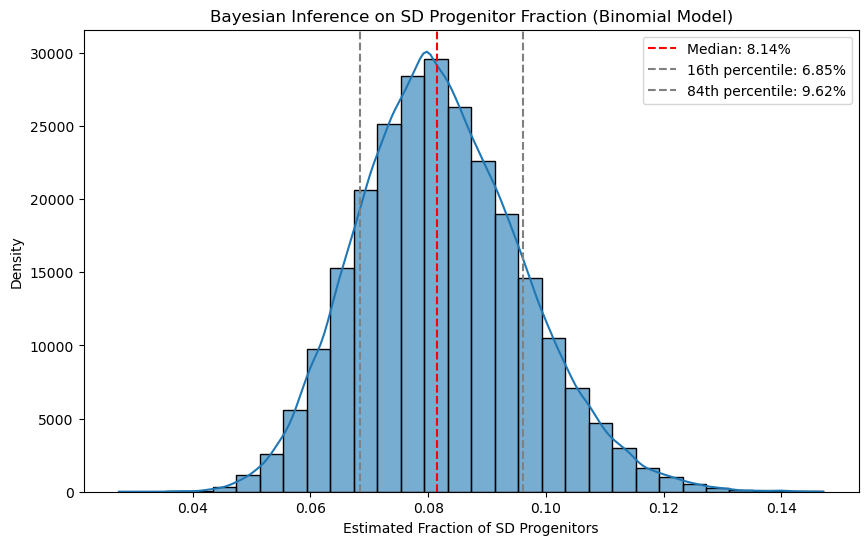